### Initialization

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.stats import truncnorm
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
from scipy.stats import norm
from ROOT import TFile, TTree

# Add the parent directory of simpleparameterisation to the sys.path list
sys.path.append('../')

# Now you can import simpleparameterisation from the new location
import TPCevt as TPC
det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")


### Datatypes

In [3]:
primary_type = np.dtype([('x', float), ('y', float), ('z', float), ('Edep', float)])
primary_nip_type = np.dtype([('x', float), ('y', float), ('z', float), ('Edep', float), ('NIP', int)])
drifted_type = np.dtype([('pidx', int), ('x', float), ('y', float), ('dt', float)])
readout_type = np.dtype([('x',float), ('y', float), ('dt', float), ('Nel', float)])

### Pre Readout & Gain Function

In [21]:
def driftsigma_trans(z, det):
    return np.sqrt(2*z*det.D_xy/det.vdrift)

def driftsigma_long(z, det):
    return np.sqrt(2*z*det.D_z/det.vdrift)

def getData(f, saveevt):
    # Get Center Coordinate
    z0_values = np.asarray([evt.z0 for evt in f.data])
    max_z = np.max(z0_values)
    min_z = np.min(z0_values)  
    center_z = (max_z - min_z)/2
    
    for i, evt in enumerate(f.data):
        if i == saveevt:
            num_carriers = len(evt.x)
            PrimaryEvt = np.empty(num_carriers, dtype=primary_type)
            PrimaryEvt['x'] = np.asarray(evt.x) / 10 + center_z / 10
            PrimaryEvt['y'] = np.asarray(evt.y) / 10 + center_z / 10
            PrimaryEvt['z'] = np.asarray(evt.z) / 10 + center_z / 10
            PrimaryEvt['Edep'] = np.asarray(evt.edep) * 1000
            break
    return PrimaryEvt

def generateCarriers(PrimaryEvt, det):
    num_carriers = len(PrimaryEvt['x'])
    
    PrimaryEvtNIP = np.empty(num_carriers, dtype=primary_nip_type)
    PrimaryEvtNIP[['x', 'y', 'z', 'Edep']] = PrimaryEvt[['x', 'y', 'z', 'Edep']]
    
    nip_list = np.random.poisson(PrimaryEvt['Edep'] / det.wval)
    
    PrimaryEvtNIP['NIP'] = nip_list
    return PrimaryEvtNIP


def driftCarriers(PrimaryEvtNIP, det):
    NIP = PrimaryEvtNIP['NIP'].astype(int)
    z_list = PrimaryEvtNIP['z'].repeat(NIP)
    num_carriers = PrimaryEvtNIP['NIP'].sum()
    
    DriftedEvt = np.empty(num_carriers, dtype=drifted_type)
    DriftedEvt['pidx'] = np.arange(len(NIP)).repeat(NIP)
    
    DriftedEvt['x'] = PrimaryEvtNIP['x'].repeat(NIP) + np.random.normal(loc=0,  scale=driftsigma_trans(z_list, det ))
    
    DriftedEvt['y'] = PrimaryEvtNIP['y'].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det ))
    
    DriftedEvt['dt'] = (PrimaryEvtNIP['z'].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det )))/det.vdrift
    
    return DriftedEvt



### Readout & Gain Function

In [8]:
pitch_x = det.pitch_x
pitch_y = det.pitch_y
pitch_z = det.samplerate
thresh = 1e1
grid_size = 100

rv = multivariate_normal([0,0,0], np.diag([det.PSFstd, det.PSFstd,det.gain_sigma_t]))

In [52]:
# Function Definition
def getDistribution(grid_size, offset, method = 'cdf'):
    x, y, z = np.mgrid[-grid_size*pitch_x:(grid_size+1)*pitch_x:pitch_x,
            -grid_size*pitch_y:(grid_size+1)*pitch_y:pitch_y,
            -grid_size*pitch_z:(grid_size+1)*pitch_z:pitch_z,
            ]
    offset_x, offset_y, offset_z = offset
    gain = np.random.exponential(scale=det.gain_mean)
    if (method =='cdf'):
        C = np.stack((np.array([x+pitch_x/2-offset_x, y+pitch_y/2-offset_y, z+pitch_z/2-offset_z])), axis=-1)
        G = np.stack((np.array([x+pitch_x/2-offset_x, y+pitch_y/2-offset_y, z-pitch_z/2-offset_z])), axis=-1)
        B = np.stack((np.array([x+pitch_x/2-offset_x, y-pitch_y/2-offset_y, z+pitch_z/2-offset_z])), axis=-1)
        F = np.stack((np.array([x+pitch_x/2-offset_x, y-pitch_y/2-offset_y, z-pitch_z/2-offset_z])), axis=-1)
        D = np.stack((np.array([x-pitch_x/2-offset_x, y+pitch_y/2-offset_y, z+pitch_z/2-offset_z])), axis=-1)
        H = np.stack((np.array([x-pitch_x/2-offset_x, y+pitch_y/2-offset_y, z-pitch_z/2-offset_z])), axis=-1)
        A = np.stack((np.array([x-pitch_x/2-offset_x, y-pitch_y/2-offset_y, z+pitch_z/2-offset_z])), axis=-1)
        E = np.stack((np.array([x-pitch_x/2-offset_x, y-pitch_y/2-offset_y, z-pitch_z/2-offset_z])), axis=-1)
        # val_substract = rv.cdf(A) - rv.cdf(E)
        # The Intuitive Equation:  val = (rv.cdf(C) - rv.cdf(G)) - ( (rv.cdf(B) - rv.cdf(F)) - val_substract ) - ( (rv.cdf(D) - rv.cdf(H)) - val_substract ) - val_substract
        val = gain * ( (rv.cdf(C) - rv.cdf(G)) -  (rv.cdf(B) - rv.cdf(F)) - (rv.cdf(D) - rv.cdf(H)) + rv.cdf(A) - rv.cdf(E) )
    else:
        val = rv.pdf(np.stack((x, y, z), axis = -1))*pitch_x*pitch_y*pitch_z*gain
    
    return x, y, z, val


def applyThreshold(x_1, y_1, z_1, readout_1, thresh):
    mask_1 = readout_1 >= thresh
    x_1_filtered = x_1[mask_1].flatten()
    y_1_filtered = y_1[mask_1].flatten()
    z_1_filtered = z_1[mask_1].flatten()
    readout_1_filtered = readout_1[mask_1]
    return x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered


def filterCoord(x, y, z, val, minvals, maxvals):
    # Convert input lists to NumPy arrays
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    val = np.array(val)

    # Define masks for filtering
    x_mask = (minvals[0] <= x) & (x <= maxvals[0])
    y_mask = (minvals[1] <= y) & (y <= maxvals[1])
    z_mask = (minvals[2] <= z) & (z <= maxvals[2])

    # Combine the masks to get the final filtering mask
    final_mask = x_mask & y_mask & z_mask
    # final_mask = 1

    # Use the filtering mask to get the filtered arrays
    filtered_x = x[final_mask]
    filtered_y = y[final_mask]
    filtered_z = z[final_mask]
    filtered_val = val[final_mask]

    return [filtered_x, filtered_y, filtered_z, filtered_val]
    # return [x, y, z, val]


def getGridProps(coord, delta):
    index = int((coord + delta / 2) // delta)
    offset = coord - index*delta
    return index, offset


def count_decimal_places(number):
    if "." not in str(number):
        return 0
    return len(str(number).split(".")[1])


def ReadoutGain(DriftedEvt, method='cdf'):
    minvals = np.array([DriftedEvt['x'].min(), DriftedEvt['y'].min(), DriftedEvt['dt'].min()])
    maxvals = np.array([DriftedEvt['x'].max(), DriftedEvt['y'].max(), DriftedEvt['dt'].max()])
    print('min and max: ', minvals, maxvals)
    CombinedEvt = {}
    comma_num_x = count_decimal_places(pitch_x)
    comma_num_y = count_decimal_places(pitch_y)
    comma_num_z = count_decimal_places(pitch_z)
    print("Comma num", comma_num_x, comma_num_y, comma_num_z)

    def combineData(x, y, z, val):
        for i in range(len(x)):
            key = (np.around(x[i], comma_num_x), np.around(y[i], comma_num_y), np.around(z[i], comma_num_z))
            if key in CombinedEvt:
                CombinedEvt[key] += val[i]
            else:
                CombinedEvt[key] = val[i]
    
    for i in range(len(DriftedEvt)):
        coord = np.array([DriftedEvt['x'][i], DriftedEvt['y'][i], DriftedEvt['dt'][i]])
        print("coord-", i, ' : ', coord)
        (index_x, offset_x) = getGridProps(coord[0], pitch_x)
        (index_y, offset_y) = getGridProps(coord[1], pitch_y)
        (index_z, offset_z) = getGridProps(coord[2], pitch_z)
        
        x_1, y_1, z_1, readout_1 = getDistribution(grid_size, [offset_x, offset_y, offset_z], method)

        x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered = applyThreshold(x_1, y_1, z_1, readout_1, thresh)
        
        x_1_filtered += index_x*pitch_x
        y_1_filtered += index_y*pitch_y
        z_1_filtered += index_z*pitch_z
        
        combineData(x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered)
        x_comb, y_comb, z_comb = zip(*CombinedEvt.keys())
        
    val_comb = list(CombinedEvt.values())
    filtered_coord = filterCoord(x_comb, y_comb, z_comb, val_comb, minvals, maxvals)
    readout_length = len(filtered_coord[0])
    ReadoutEvt = np.empty(readout_length, dtype=readout_type)
    ReadoutEvt['x'] = filtered_coord[0]
    ReadoutEvt['y'] = filtered_coord[1]
    ReadoutEvt['dt'] = filtered_coord[2]
    ReadoutEvt['Nel'] = filtered_coord[3]
    return ReadoutEvt


### Plot Function

In [25]:
def plotReadout(ReadoutEvt):
    x = ReadoutEvt['x']
    y = ReadoutEvt['y']
    dt = ReadoutEvt['dt']
    Nel = ReadoutEvt['Nel']
    
    # ========================== x y ========================== 
    ### Create unique combinations of x and y values
    unique_xy, unique_indices = np.unique(np.column_stack((x, y)), axis=0, return_index=True)
    unique_Nel = np.zeros(len(unique_xy))  # Initialize an array for summed Nel values

    # Calculate summed Nel values for each unique (x, y) pair
    for i, idx in enumerate(unique_indices):
        mask = (x == x[idx]) & (y == y[idx])
        unique_Nel[i] = np.sum(Nel[mask])

    # Create a new structured array with unique (x, y) pairs and summed Nel values
    dtype = np.dtype([('x', x.dtype), ('y', y.dtype), ('Nel', unique_Nel.dtype)])
    projectxy = np.empty(len(unique_xy), dtype=dtype)
    projectxy['x'] = unique_xy[:, 0]
    projectxy['y'] = unique_xy[:, 1]
    projectxy['Nel'] = unique_Nel
    plt.figure(0)
    plt.scatter(projectxy['x'], projectxy['y'], c = projectxy['Nel'], s = ((projectxy['Nel']/np.max(projectxy['Nel']))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" X-Y Chart ")
    
    # ========================== x dt ========================== 
    ### Create unique combinations of x and dt values
    unique_xdt, unique_indices = np.unique(np.column_stack((x, dt)), axis=0, return_index=True)
    unique_Nel = np.zeros(len(unique_xdt))  # Initialize an array for summed Nel values

    # Calculate summed Nel values for each unique (x, y) pair
    for i, idx in enumerate(unique_indices):
        mask = (x == x[idx]) & (dt == dt[idx])
        unique_Nel[i] = np.sum(Nel[mask])

    # Create a new structured array with unique (x, y) pairs and summed Nel values
    dtype = np.dtype([('x', x.dtype), ('dt', dt.dtype), ('Nel', unique_Nel.dtype)])
    projectxdt = np.empty(len(unique_xdt), dtype=dtype)
    projectxdt['x'] = unique_xdt[:, 0]
    projectxdt['dt'] = unique_xdt[:, 1]
    projectxdt['Nel'] = unique_Nel
    plt.figure(1)
    plt.scatter(projectxdt['x'], projectxdt['dt'], c = projectxdt['Nel'], s = ((projectxdt['Nel']/np.max(projectxdt['Nel']))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" X-dt Chart ")
    
    
    # ========================== y dt ========================== 
    ### Create unique combinations of y and dt values
    unique_ydt, unique_indices = np.unique(np.column_stack((y, dt)), axis=0, return_index=True)
    unique_Nel = np.zeros(len(unique_ydt))  # Initialize an array for summed Nel values

    # Calculate summed Nel values for each unique (y, dt) pair
    for i, idx in enumerate(unique_indices):
        mask = (y == y[idx]) & (dt == dt[idx])
        unique_Nel[i] = np.sum(Nel[mask])

    # Create a new structured array with unique (y, dt) pairs and summed Nel values
    dtype = np.dtype([('y', y.dtype), ('dt', dt.dtype), ('Nel', unique_Nel.dtype)])
    projectydt = np.empty(len(unique_ydt), dtype=dtype)
    projectydt['y'] = unique_ydt[:, 0]
    projectydt['dt'] = unique_ydt[:, 1]
    projectydt['Nel'] = unique_Nel
    plt.figure(2)
    plt.scatter(projectydt['y'], projectydt['dt'], c = projectydt['Nel'], s = ((projectydt['Nel']/np.max(projectydt['Nel']))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" Y-dt Chart ")
    
    # ========================== 3d chart ========================== 
    fig = plt.figure(3)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    scatter = ax.scatter(x, y, dt, c=Nel, cmap='viridis', marker='o')
    plt.title(" X-Y-Z Chart")
    plt.colorbar(scatter)
    plt.show()

### Pre-Readout

In [11]:
# Open ROOT FIle
f = TFile.Open("../../data/simOut_28796KShell.root")

In [15]:
saveevt = 1
PrimaryEvt = getData(f, saveevt)
print(PrimaryEvt)

[(23.96216995, 26.85175507, 26.81491108, 0.04367   )
 (23.96236844, 26.85199061, 26.81491721, 0.08379162)
 (23.96232853, 26.85212054, 26.81493353, 0.13658838)
 (23.96212538, 26.85179556, 26.81487233, 0.04938   )
 (23.96135451, 26.84998614, 26.81505773, 0.02197296)
 (23.95760213, 26.84808033, 26.81632938, 0.66581724)
 (23.95678299, 26.84591105, 26.81451088, 0.37601499)
 (23.95728105, 26.84457497, 26.81278977, 0.43389704)
 (23.95709306, 26.84605251, 26.81273998, 0.01602529)
 (23.95771294, 26.84490717, 26.81340867, 1.05244247)]


In [ ]:
PrimaryEvtNIP = generateCarriers(PrimaryEvt, det)
print(PrimaryEvtNIP)

In [ ]:
DriftedEvt = driftCarriers(PrimaryEvtNIP, det)
print(DriftedEvt)

In [53]:
pitch_x = det.pitch_x
pitch_y = det.pitch_y
pitch_z = det.samplerate
thresh = 0.1
grid_size = 50

rv = multivariate_normal([0,0,0], np.diag([det.PSFstd, det.PSFstd,det.gain_sigma_t]))

In [54]:
ReadoutEvt = ReadoutGain(DriftedEvt, method='pdf')

min and max:  [23.74240195 26.51897888  0.15619724] [24.19346937 27.25039531  0.15966184]
Comma num 1 1 3
coord- 0  :  [23.80937913 26.88675717  0.15665465]
coord- 1  :  [23.99447011 26.65076952  0.15859343]
coord- 2  :  [24.19346937 26.69760273  0.15780209]
coord- 3  :  [24.02983485 27.00579613  0.15781805]
coord- 4  :  [23.86173846 27.06115177  0.15777281]
coord- 5  :  [24.11098646 26.86617634  0.15778242]
coord- 6  :  [23.9387313  27.06697727  0.15753262]
coord- 7  :  [24.15257373 26.93364338  0.15855376]
coord- 8  :  [24.02646407 26.84039544  0.15870861]
coord- 9  :  [24.13365643 26.84421185  0.15717105]
coord- 10  :  [23.82015116 26.88271863  0.15816283]
coord- 11  :  [24.0030169  26.95572683  0.15643134]
coord- 12  :  [23.91187473 26.658489    0.15751973]
coord- 13  :  [23.95456791 26.94122513  0.15779419]
coord- 14  :  [23.82257887 26.68726109  0.15716265]
coord- 15  :  [24.00145062 26.83121902  0.15873996]
coord- 16  :  [24.12802134 27.11135035  0.15698778]
coord- 17  :  [24.02

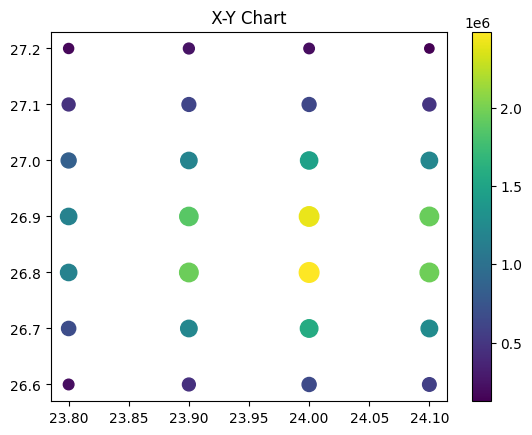

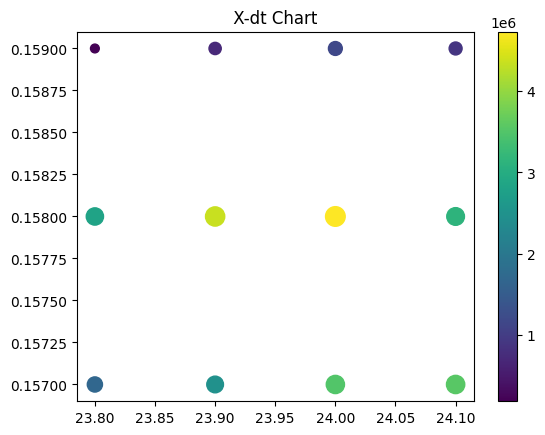

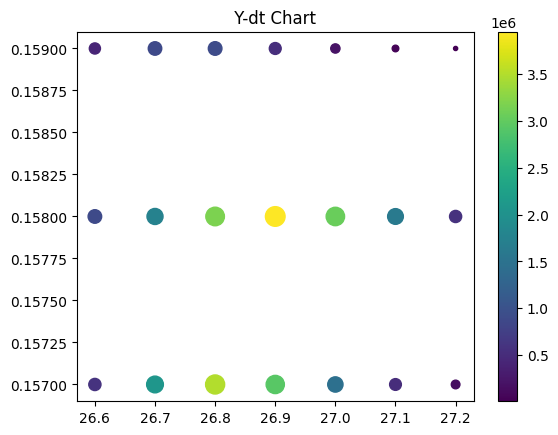

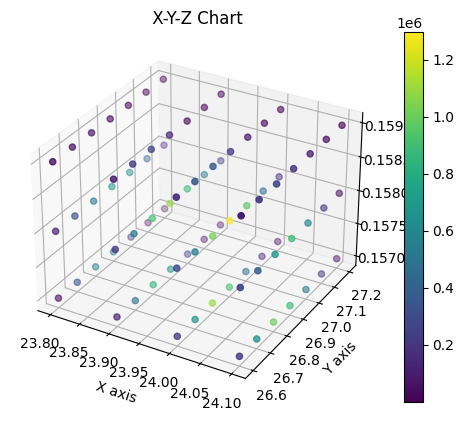

In [55]:
chart_scaling = 200
plotReadout(ReadoutEvt)